# Introduction

This is a personal project to grasp some concept of SET50 Options pricing.  The historical Options price was mannually collected by myself on a daily basis with a Google Sheet during those trading days. 

Here is how it lool like on a speadsheet:

![options_sheet](options_sheet.png)

I have been trading Options for several years and still wanting to better understand the pricing of the Options, so, as a data analyst, I think I will use some of the DA tools to help me grasp a better picture of Options Pricing.

----------------

Options is a derivative origanally aim to be used as an insurance for an underlying asset volatility during a certain period of time. And just like any insurances, the buyer need to pay the insurance premium to get insured, but, a million dollar question is, "How much" you should pay or sell for an option at a certain time.

Since Options premium depends a lot on: 
- underlying's volatility and 
- time to expiration 
This notebook thus aim to map Options premium to both of the factors.

For anyone who want to learn more about Options, here's a [link](https://www.investopedia.com/terms/s/stockoption.asp) to lay some foundation. 

----------------

**Thailand Future Exchange(TFEX)** is a derivative market wich provides wide range of derivative such as "Index Future" and "Index Options". Each contracts expired at the end of each quarters and coded by the letter and numbers. Here is how to read the contract symbol:

 * S50H20 -> Means: this is an SET50 Index Future Expired at March 2020.
 
 * S50M20C900 -> Means: this is an SET50 Index Options at Strike Price 900 Expired at June 2020.
 
 The month code are as follows:
 
 * H -> March Expiration
 * M -> June Expiration
 * U -> September Expiration
 * Z -> December Expiration
 
 Thus **S50U22** is an **SET50 Index Future Contract expired at September 2022.**
 
 
 For more detailed explanation, please visit the [exchange](https://www.tfex.co.th/tfex/index.html?locale=en_US) tutorial.

-----------------------

Thanak Rattanopastkul, 2022 

# Dataset's Note

There are 2 datasets in this notebook.
* Merged-Table 1.csv
* option_premium.csv

### Merged-Table 1.csv
This dataset is a historical price of SET50 Futures, an equity index future of Thailand's Stock Exchange. I Collected directly from the **TFEX**(Thailand's Future Exchange) [website](https://www.tfex.co.th/tfex/dailyMarketReport.html?locale=en_US) and merge all the series together and add a trading SYMBOL to every observations.
    
The collumns in Merged-Table 1.csv are as follows:
* **Date** -> Trading day
* **Open** -> Opening price
* **High** -> Higest price duing the day
* **Low** -> Lowest price duing the day
* **Close** -> Closing price
* **SP** -> [Settlement price](https://www.investopedia.com/terms/s/settlementprice.asp)
* **Chg** -> Price change from last trading day
* **%Chg** -> Price percent change from last trading day
* **Vol** -> Trading volume
* **OI** -> [Open Interest](https://www.investopedia.com/terms/o/openinterest.asp)
* **Series** -> Trading symbol

### option_premiun.csv
This is a dataset manually collected by myself at the end of each trading day to record the price movement and any market beheaviors. I take only the relevant features and exported the dataset to CSV file.

The collumns in Merged-Table 1.csv are as follows:
* **Date** -> Trading day
* **Series Name** -> Trading Symbol
* **Underlying Close** -> Nearest SET50 Future Contract closing price 
* **Expiration** -> Options Expiration Date
* **Day to expire** -> Day count to expiration
* **Underlying Change** -> Nearest SET50 Future Contract price change from last observation
* **ATM premium** -> SUM of Put and Call Options Premium at the [ATM](https://www.investopedia.com/terms/a/atthemoney.asp)
* **+/-1 OTM premium** -> SUM of Put and Call Options Premium at the [+1 Call and -1 Put](https://www.investopedia.com/terms/o/outofthemoney.asp)


### Import Dependencies

In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import gc

import warnings
warnings.filterwarnings('ignore')

### Read the Data

In [362]:
path_1 = os.getcwd()+'/Merged-Table 1.csv'
merged_future = pd.read_csv(path_1, 
                  parse_dates=['Date'],
                  infer_datetime_format=True,
                  dayfirst=True,
)

path_2 = os.getcwd()+'/option_premium.csv'

manual_data = pd.read_csv(path_2, 
                  parse_dates=['date','Expiration'],
                  infer_datetime_format=True,
                  dayfirst=True
)

In [363]:
merged_future.head()

,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
0,2019-06-28,"1,144.5","1,149.5","1,143.4","1,148.4","1,148.20",1.90,0.0017,"115,738","316,223",U19
1,2019-07-01,"1,161.9","1,163.6","1,155.4","1,157.2","1,157.30",9.10,0.0079,"133,682","321,194",U19
2,2019-07-02,"1,153.5","1,156.1","1,149.3","1,150.4","1,150.60",-6.70,-0.0058,"119,790","325,410",U19
3,2019-07-03,"1,150.0","1,155.9","1,148.1","1,153.3","1,153.20",2.60,0.0023,"124,920","340,505",U19
4,2019-07-04,"1,153.2","1,157.4","1,136.7","1,141.8","1,142.20",-11.00,-0.0095,"199,165","324,931",U19


In [364]:
merged_future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    722 non-null    datetime64[ns]
 1   Open    722 non-null    object        
 2   High    722 non-null    object        
 3   Low     722 non-null    object        
 4   Close   722 non-null    object        
 5   SP      722 non-null    object        
 6   Chg     722 non-null    object        
 7   %Chg    722 non-null    object        
 8   Vol     722 non-null    object        
 9   OI      722 non-null    object        
 10  Series  722 non-null    object        
dtypes: datetime64[ns](1), object(10)
memory usage: 62.2+ KB


In [365]:
manual_data.head()

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
0,2019-06-18,U19,1111.8,2019-09-27,101d,NaN,38.8,20.9
1,2019-06-19,U19,1131.2,2019-09-27,100d,19.4,39.4,22.1
2,2019-06-20,U19,1144.4,2019-09-27,99d,13.2,44.7,24.8
3,2019-06-21,U19,1141.6,2019-09-27,98d,-2.8,47.0,26.7
4,2019-06-24,U19,1139.2,2019-09-27,95d,-2.4,48.6,28.0


In [366]:
manual_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595 entries, 0 to 594
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               595 non-null    datetime64[ns]
 1   Series Name        595 non-null    object        
 2   Underlying Close   594 non-null    float64       
 3   Expiration         595 non-null    datetime64[ns]
 4   Day to expire      595 non-null    object        
 5   Underlying Change  585 non-null    float64       
 6   ATM premium        592 non-null    float64       
 7   +/-1 OTM premium   595 non-null    float64       
dtypes: datetime64[ns](2), float64(4), object(2)
memory usage: 37.3+ KB


Many fof the merge_future data are in from of stings. Need to change it in to float and int.

Eyeballing the CSV, there are some value in **Chg** and **%Chg** are "-" let's see if they can be recalculated. 

In [367]:
dashed_index =  merged_future.loc[(merged_future['Chg'] == '-') | (merged_future['%Chg']=='-')].index

for i in dashed_index:
    display(merged_future.loc[i-1:i+1])

,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
91,2019-11-11,"1,097.0","1,097.5","1,090.0","1,094.2","1,094.00",-8.50,-0.0077,"151,618","301,573",Z19
92,2019-11-12,"1,094.3","1,100.8","1,092.5","1,094.0","1,094.00",-,-,"141,739","295,725",Z19
93,2019-11-13,"1,089.5","1,093.4","1,084.7","1,089.0","1,088.80",-5.20,-0.0048,"165,193","291,879",Z19


,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
131,2020-01-13,"1,071.0","1,074.5","1,068.2","1,072.0","1,071.80",3.10,0.0029,"142,138","297,896",H20
132,2020-01-14,"1,074.8","1,075.0","1,065.1","1,071.7","1,071.80",-,-,"162,436","302,060",H20
133,2020-01-15,"1,067.5","1,069.3","1,062.5","1,064.4","1,064.50",-7.30,-0.0068,"152,343","308,214",H20


,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
137,2020-01-21,"1,065.5","1,068.0","1,060.1","1,060.4","1,060.50",-9.40,-0.0088,"175,914","331,458",H20
138,2020-01-22,"1,062.1","1,064.5","1,057.1","1,060.7","1,060.50",-,-,"166,388","343,044",H20
139,2020-01-23,"1,056.1","1,060.3","1,054.0","1,058.3","1,058.50",-2.00,-0.0019,"121,237","338,445",H20


,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
239,2020-06-22,902.0,903.6,890.2,897.0,896.80,-13.20,-0.0145,"130,194","196,844",M20
240,2020-06-23,896.6,900.8,893.2,896.6,896.80,-,-,"100,486","186,305",M20
241,2020-06-24,899.0,902.7,877.1,877.1,878.90,-17.90,-0.02,"169,755","190,212",M20


,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
551,2021-10-12,985.7,991.0,982.6,987.6,987.40,6.20,0.0063,"129,675","343,351",Z21
552,2021-10-14,993.0,994.0,983.3,987.9,987.40,-,-,"145,559","347,819",Z21
553,2021-10-15,989.0,992.0,984.5,986.5,986.50,-0.90,-0.0009,"125,500","349,164",Z21


Seems like the recalculation is possible. Let's change the dtype to string and calculate the Chg and %Chg.

In [368]:
for i in merged_future.index:
    
        if merged_future.loc[i, 'Chg'] != '-':
            for col in ['Open', 'High', 'Low', 'Close', 'SP', 'Chg','%Chg','Vol','OI']:
                merged_future.loc[i, col] = float(merged_future.loc[i, col].replace('"','').replace(',',''))
        else:
            col2 = ['Open', 'High', 'Low', 'Close', 'SP','Vol','OI']
            for col2 in col2:   
                merged_future.loc[i, col2] = float(merged_future.loc[i, col2].replace('"','').replace(',',''))

            merged_future.loc[i, 'Chg'] = float(9.9) #temp
            merged_future.loc[i, '%Chg'] = float(9.9) #temp
            merged_future.loc[i, 'Chg'] = merged_future.loc[i, 'SP'] - merged_future.loc[i-1, 'SP']
            merged_future.loc[i, '%Chg'] = (merged_future.loc[i, 'SP'] - merged_future.loc[i-1, 'SP'])/merged_future.loc[i-1, 'SP']


Check if all the data are of dtype strings and no "-" on **Chg** and **%Chg**.

In [369]:
merged_future.loc[dashed_index]

,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
92,2019-11-12,1094.3,1100.8,1092.5,1094.0,1094.0,0.0,0.0,141739.0,295725.0,Z19
132,2020-01-14,1074.8,1075.0,1065.1,1071.7,1071.8,0.0,0.0,162436.0,302060.0,H20
138,2020-01-22,1062.1,1064.5,1057.1,1060.7,1060.5,0.0,0.0,166388.0,343044.0,H20
240,2020-06-23,896.6,900.8,893.2,896.6,896.8,0.0,0.0,100486.0,186305.0,M20
552,2021-10-14,993.0,994.0,983.3,987.9,987.4,0.0,0.0,145559.0,347819.0,Z21


"merged_future" contains 722 observations from SET50 Index Future from 2019 to 2022.
"manual_data" contains 595 observations from SET0 Index Future and Options from 2019 to 2021.

Since "merged_future" contains better Future Contracts trading data, The plan is to validate the data and merge two tables into one using Future data from "merged_future" and Options data from "manual_data".

### Check and Validate data

In [370]:
merged_future.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
SP        0
Chg       0
%Chg      0
Vol       0
OI        0
Series    0
dtype: int64

In [371]:
manual_data.isna().sum()

date                  0
Series Name           0
Underlying Close      1
Expiration            0
Day to expire         0
Underlying Change    10
ATM premium           3
+/-1 OTM premium      0
dtype: int64

Only some data from the manually collected data are missing. For the missing "Underlying Close" and "Underlying Change" , we can replace with the "Close" and "Chg" from the other dataset.

Let's see the missing "ATM premium".

In [372]:
manual_data.loc[manual_data['ATM premium'].isna()]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium
188,2020-03-09,H20,822.3,2020-03-30,21d,-92.3,NaN,0.0
191,2020-03-12,H20,724.1,2020-03-30,18d,-97.6,NaN,0.0
204,2020-03-23,M20,663.1,2020-06-29,98d,NaN,NaN,119.0


For the entries at 

* 2020-03-09 
* 2020-03-12
* 2020-03-23 

those are very special case when COVID-19 crash the global market. The market actually crash and [Circuit Breaker](https://www.investopedia.com/terms/c/circuitbreaker.asp) was implimented on those three days. The Options market maker stop providing liquidity. Thus, those three very rare occasions should be dropped.

In [373]:
manual_data.dropna(inplace=True)

### Check Entry Duplications

In [374]:
manual_data.loc[manual_data.duplicated()]

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium


In [375]:
merged_future.loc[merged_future.duplicated()]

,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series


### Merge Data

Will use date and Series as merging keys and extract only the needed columns.

In [376]:
merged_future_options = pd.merge(left=manual_data,right=merged_future,left_on=['date','Series Name'],right_on=['Date','Series'])
merged_future_options.head(3)

,date,Series Name,Underlying Close,Expiration,Day to expire,Underlying Change,ATM premium,+/-1 OTM premium,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series
0,2019-06-28,U19,1148.4,2019-09-27,91d,3.2,43.8,24.4,2019-06-28,1144.5,1149.5,1143.4,1148.4,1148.2,1.9,0.0017,115738.0,316223.0,U19
1,2019-07-01,U19,1157.2,2019-09-27,88d,8.8,42.3,21.7,2019-07-01,1161.9,1163.6,1155.4,1157.2,1157.3,9.1,0.0079,133682.0,321194.0,U19
2,2019-07-02,U19,1150.4,2019-09-27,87d,-6.8,40.8,20.7,2019-07-02,1153.5,1156.1,1149.3,1150.4,1150.6,-6.7,-0.0058,119790.0,325410.0,U19


In [377]:
a = list(merged_future.columns) #all columns taken 
a.extend(['Expiration','Day to expire','ATM premium','+/-1 OTM premium']) #extend with only needed column from another dataset.
ready_df = merged_future_options[a]

# delete the unused variable
del [path_1,path_2,merged_future,manual_data,merged_future_options,dashed_index,col,col2]
gc.collect()

0

In [391]:
ready_df.head()

,Date,Open,High,Low,Close,SP,Chg,%Chg,Vol,OI,Series,Expiration,Day to expire,ATM premium,+/-1 OTM premium
0,2019-06-28,1144.5,1149.5,1143.4,1148.4,1148.2,1.9,0.0017,115738.0,316223.0,U19,2019-09-27,91d,43.8,24.4
1,2019-07-01,1161.9,1163.6,1155.4,1157.2,1157.3,9.1,0.0079,133682.0,321194.0,U19,2019-09-27,88d,42.3,21.7
2,2019-07-02,1153.5,1156.1,1149.3,1150.4,1150.6,-6.7,-0.0058,119790.0,325410.0,U19,2019-09-27,87d,40.8,20.7
3,2019-07-03,1150.0,1155.9,1148.1,1153.3,1153.2,2.6,0.0023,124920.0,340505.0,U19,2019-09-27,86d,39.5,20.5
4,2019-07-04,1153.2,1157.4,1136.7,1141.8,1142.2,-11.0,-0.0095,199165.0,324931.0,U19,2019-09-27,85d,40.9,21.8


### EDA

Let's put all the most important features together to see the pattern. 
* Underlying Price (Close)
* Trading Volume
* Open Interest
* Options price for both ATM an OTM


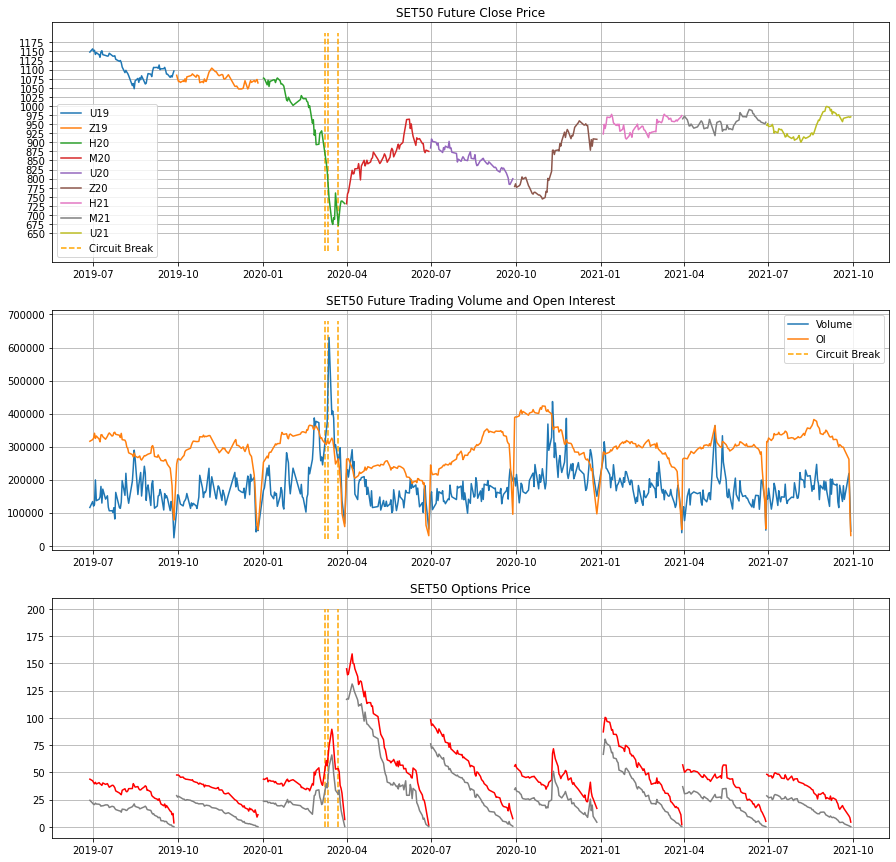

In [431]:
interval = [i*25 for i in range(26,48)] #to vertically frame between 650 - 1248 and use as yticks

fig = plt.subplots(figsize=(15,15))
plt.subplot(311)
for symbol in ready_df['Series'].unique():
    plt.plot(ready_df.loc[ready_df['Series'] == symbol, 'Date'],
                    ready_df.loc[ready_df['Series'] == symbol, 'Close'],label=symbol)
plt.title('SET50 Future Close Price')
plt.grid()
plt.yticks(interval)
plt.vlines(['2020-03-09','2020-03-12','2020-03-23'],ymin=600,ymax=1200,label='Circuit Break',linestyles='dashed',colors='orange')
plt.legend()

plt.subplot(312)
plt.title('SET50 Future Trading Volume and Open Interest')
plt.plot(ready_df.Date,ready_df.Vol,label='Volume')
plt.plot(ready_df.Date,ready_df.OI,label='OI')
plt.vlines(['2020-03-09','2020-03-12','2020-03-23'],ymin=20000,ymax=680000,label='Circuit Break',linestyles='dashed',colors='orange')
plt.grid()
plt.legend()

plt.subplot(313)
plt.title('SET50 Options Price')
for symbol in ready_df['Series'].unique():
    plt.plot(ready_df.loc[ready_df['Series'] == symbol, 'Date'],
                    ready_df.loc[ready_df['Series'] == symbol, 'ATM premium'],c='r',label='ATM premiun')
for symbol in ready_df['Series'].unique():
    plt.plot(ready_df.loc[ready_df['Series'] == symbol, 'Date'],
                    ready_df.loc[ready_df['Series'] == symbol, '+/-1 OTM premium'],c='0.5',label='OTM premium')
plt.vlines(['2020-03-09','2020-03-12','2020-03-23'],ymin=0,ymax=200,label='Circuit Break',linestyles='dashed',colors='orange')
plt.grid()

plt.show()

### What do we see form EDA
There are a lot to take in from the above chart.

In [432]:
### Current Working Cell

### Feature Engineering

Options price affected the most by time to expiration and underlying volatility. Let's calculate the change in Options price and underlying "ATR (Average True Range) to represent volatility.

Further explanation of [ATR](https://www.investopedia.com/terms/a/atr.asp)